#KNN Implementation

###Load Dataset and Preprocessing


In [4]:
%cd /content/drive/My Drive/PMDL/A1/Part1


/content/drive/My Drive/PMDL/A1/Part1


In [ ]:
!wget http://download.tensorflow.org/example_images/flower_photos.tgz

In [ ]:
! tar -xvzf /content/drive/My\ Drive/PMDL/A1/Part1/flower_photos.tgz

In [1]:
import os
import cv2 
import numpy as np
from skimage.transform import resize #to resize img
from scipy import stats


In [ ]:
def load_data():
  pd="/content/drive/My Drive/PMDL/A1/Part1/flower_photos"
  dirs=sorted(os.listdir(pd))
  flowers_train=[]
  classes_train=[]
  flowers_test=[]
  classes_test=[]
  c=1
  for f in dirs:
    dir=os.path.join(pd,f)
    if os.path.isdir(dir):
      fs=sorted(os.listdir(dir))
      cls=[]
      cl=len(fs)
      for j,k in enumerate(fs):
        #read img, then resize to 32 by 32 (I tried multiple sizes and this yeilded best accuracy)
        img=(cv2.imread(os.path.join(dir,k)))
        img = resize(img, (32, 32,3))
        if cl-(j+1)>=100: 
          flowers_train.append(np.array(img)) 
          classes_train.append(c)
        else:#keep last 100 of each class for test
          flowers_test.append(np.array(img)) 
          classes_test.append(c)
      c+=1
  flowers_train=np.array(flowers_train)
  classes_train=np.array(classes_train)
  flowers_test=np.array(flowers_test)
  classes_test=np.array(classes_test)
  #flatten the train and test data then return
  return (flowers_train.reshape(flowers_train.shape[0],-1),classes_train,flowers_test.reshape(flowers_test.shape[0],-1),classes_test)
    


In [ ]:
#classes  {1: daisy, 2: dandelion, 3: roses, 4: sunflowers, 5: tulips} #meaning of each class
X_train,y_train,X_test,y_test=load_data()

In [ ]:
#shuffle the arrays
from sklearn.utils import shuffle
X_train,y_train=shuffle(X_train,y_train)
X_test,y_test=shuffle(X_test,y_test)

In [ ]:
#save arrays
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)


###KNN Class

In [5]:
#load numpy dataset arrays
X_train=np.load("X_train.npy")
y_train=np.load("y_train.npy")
X_test=np.load("X_test.npy")
y_test=np.load("y_test.npy")


In [6]:
class KNN():
  def __init__(self):
    pass
  def train(self,X,Y):
    self.Xt=X
    self.yt=Y
  def distance(self,a,b,method='L2'):
    if method=='L1': #manhatan
      return np.sum(np.abs(a-b),axis=-1)
    elif method=='L2': #ecludian dist
      return np.sqrt(np.sum(np.square(a - b), axis = -1))
  def predict(self,X_test,y_test,k,dist_method='L2'):
    n_t=X_test.shape[0]
    m=X_test.shape[-1]
    y_pred=[]
    distances=[]
    for i,el in enumerate(X_test):
      distances.append(self.distance(self.Xt,X_test[i],dist_method))
    distances=np.array(distances)
    sorted_dist_args=np.argsort(distances,axis=-1)[:,:k] #get arguments of the closest points
   
    cls=np.array([])
    for dis in sorted_dist_args:
      cls=self.yt[dis] #get indices of the closest classes
      V,C=np.unique(cls,return_counts=True)
      y_pred.append(V[np.argmax(C)]) # get the most occured class
    acc=np.sum(y_test==y_pred)/n_t # return the accuracy
    return np.array(y_pred),acc




    


###K_folds to find best K

In [9]:
def K_folds(n_folds, dist="L2"):
  #try Ks as odd numbers from 1 to the 12 of the fold size as well as some high numbers
  Ks=list(range(1,13))+[20,30,50,100,200]
  accs=[]
  groups=np.array(list(range(n_folds)))
  Xs=np.array(np.split(X_train,n_folds))
  ys=np.array(np.split(y_train,n_folds))
  for k in Ks:
    acc=[]
    for i in range(n_folds):
      train_groups=groups !=i
      val_groups=groups==i
      Xtr=(np.array(np.concatenate(Xs[train_groups])))
      Xval=np.squeeze(Xs[val_groups])
      Ytr=np.array(np.concatenate(ys[train_groups]))
      Yval=ys[val_groups]
      clf=KNN()
      clf.train(Xtr,Ytr)
      yp,ac=clf.predict(Xval,Yval,k,dist)
      acc.append(ac)
    accs.append(np.mean(acc))
  return accs,Ks
        

In [10]:
# try for L2 distance
accs,Ks=K_folds(5)

In [11]:
import matplotlib.pyplot as plt


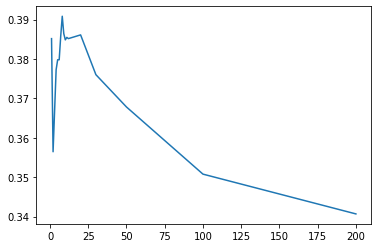

In [12]:
#plt K values vs accuracies 
plt.plot(Ks,accs)
plt.show()

In [13]:
best_k_L2=Ks[np.argmax(accs)]

In [14]:
np.save("accs_L2.npy",accs)

In [15]:
#try for L1 distance
accs,Ks=K_folds(5,"L1")
np.save("accs_L1.npy",accs)
np.save("Ks.npy",Ks)


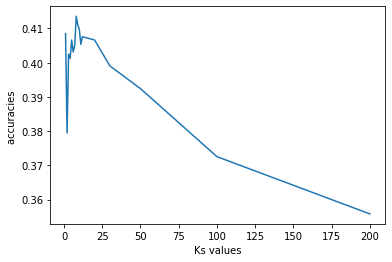

In [16]:
plt.plot(Ks,accs)
plt.xlabel("Ks values")
plt.ylabel("accuracies ")
plt.show()
best_k_L1=Ks[np.argmax(accs)]

#### It is evident from both graphs that the best k is 8 with distance method L1


###Prediction on Test set using K=8 and L1

In [17]:
clf=KNN()
clf.train(X_train,y_train)
yp,acc=clf.predict(X_test,y_test,8,'L1')

#####CCRn function

In [18]:
def CCRn(yt,yp):
  cls,counts=np.unique(yt,return_counts=True)
  ccrns={}
  cls_sizes={}
  for i,y in enumerate(yt):
    if y in cls_sizes:
      cls_sizes[y]+=1
    else:
      cls_sizes[y]=1
    if yp[i]==y:
      if y in ccrns:
        ccrns[y]+=1
      else:
        ccrns[y]=1
  for c in cls:
    ccrns[c]/=cls_sizes[c] #return accuracy by dividing over size of each class 
  return ccrns
  
    

In [19]:
ccrns=CCRn(y_test,yp)
print("ccrns dict:", ccrns)

ccrns dict: {4: 0.58, 2: 0.89, 5: 0.11, 1: 0.14, 3: 0.15}


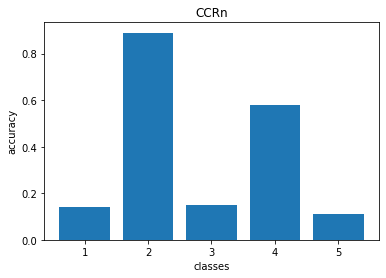

In [20]:
#represent them in bar chart
plt.bar(ccrns.keys(),ccrns.values())
plt.xlabel("classes")
plt.ylabel("accuracy")
plt.title("CCRn")
plt.show()

#####ACCR
######It is returned by default with y_pred from the prediction function of the KNN class (look at KNN.predict for refrence)

In [21]:
print("ACCR:",acc)

ACCR: 0.374


In [22]:
#compare against SKlearn KNN classifier with the same N neighbors for refrence.
from sklearn.neighbors import KNeighborsClassifier
cl=KNeighborsClassifier(n_neighbors=8,metric='manhattan')
cl.fit(X_train,y_train)
ypp=cl.predict(X_test)
from sklearn.metrics import accuracy_score
print("Sklearn KNN accuracy:", accuracy_score(y_test,ypp))

Sklearn KNN accuracy: 0.374


###Test K=8 and L1 dist on grey scale images

In [23]:
# reshape X_train, X_test and covert them to grey
def convert_grey(img):
    return np.dot(img[:,:,:3], [0.2989, 0.587, 0.144]) #convert to grey using X_grey = X_red*0.299+X_green*o.587+X_blue*0.144
Xt_grey=[]
X_test_grey=[]
for i in range(X_train.shape[0]):
  Xt_grey.append(X_train[i].reshape(-1,1))
  Xt_grey[i]=Xt_grey[i].reshape(32,32,3)
  Xt_grey[i]=convert_grey(Xt_grey[i])
for i in range(X_test.shape[0]):
  X_test_grey.append(X_train[i].reshape(-1,1))
  X_test_grey[i]=X_test_grey[i].reshape(32,32,3)
  X_test_grey[i]=convert_grey(X_test_grey[i])
Xt_grey=np.array(Xt_grey)
Xt_grey=(Xt_grey.reshape(Xt_grey.shape[0],-1))
X_test_grey=np.array(X_test_grey)
X_test_grey=(X_test_grey.reshape(X_test_grey.shape[0],-1))


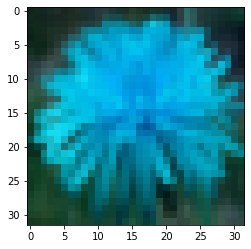

In [24]:
# show samples of the conversion
plt.imshow(X_train[9].reshape(32,32,3))

(<matplotlib.image.AxesImage at 0x7f085f0b7ac8>,)

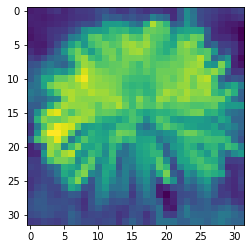

In [25]:
plt.imshow(Xt_grey[9].reshape(32,32)),

In [26]:
#try the classifier on grey scale images
clf=KNN()
clf.train(Xt_grey,y_train)
yp,acc=clf.predict(X_test_grey,y_test,8,'L1')

In [27]:
print("gery Scale ACCR:", acc)

gery Scale ACCR: 0.206


In [28]:
#compare against SK learn KNN clf
from sklearn.neighbors import KNeighborsClassifier
cl=KNeighborsClassifier(n_neighbors=8,metric='manhattan')
cl.fit(Xt_grey,y_train)
ypp=cl.predict(X_test_grey)
from sklearn.metrics import accuracy_score
print("Sklearn KNN accuracy:", accuracy_score(y_test,ypp))

Sklearn KNN accuracy: 0.206


In [29]:
##Clearly, the color images return much more accuracy than the grey scale ones.